# QM9 - Quantum chemistry structures and properties of 134 kilo molecules

### 1. Description of the dataset
The qm9 dataset holds information on the energetic, electronic and thermodynamic properties of 134 kilo molecules composed of carbon, hidrogen, oxigen, nitrogen and phosphorus atoms [1]. Information on the atomic cartesian coordinates for each molecule is also presented and they are all stored in a plain text format known as XYZ. Such dataset is often used for training and test of machine learning models, specially those who seek to identify relationships between the structure and the properties of a molecule [2,3]. More information of the qm9 content can be seen on tables 1 and 2.

**Table 1** - XYZ-like file format for molecular structure and properties.

| Line      | Content                                                                           |
|-----------|-----------------------------------------------------------------------------------|
| 1         | Number of atoms n                                                                 |
| 2         | Scalar properties                                                                 |
| 3,...,n+2 | Element type, coordinate (x, y, z in A), Mulliken partial charges (in e) on atoms |
| n+3       | Harmonic vibrational frequencies (3n-5 or 3n-6 in cm-1)                           |
| n+4       | SMILES strings from GDB-17 and from B3LYP relaxation                              |
| n+5       | InChI string for Corina and B3LYP geometries                                      |

**Table 2** - Calculated properties. Properties are stored in the order given by the first column.

| No. | Property | Unit      | Description                             |
|-----|----------|-----------|-----------------------------------------|
| 1   | tag      | -         | ‘gdb9’ string to facilitate extraction  |
| 2   | i        | -         | Consecutive, 1-based integer identifier |
| 3   | A        | GHz       | Rotational constant                     |
| 4   | B        | GHz       | Rotational constant                     |
| 5   | C        | GHz       | Rotational constant                     |
| 6   | μ        | D         | Dipole moment                           |
| 7   | α        | a³        | Isotropic polarizability                |
| 8   | homo     | Ha        | Energy of HOMO                          |
| 9   | lumo     | Ha        | Energy of LUMO                          |
| 10  | gap      | Ha        | Gap (lumo − homo)                       |
| 11  | R²       | Ha        | Electronic spatial extent               |
| 12  | zpve     | Ha        | Zero point vibrational energy           |
| 13  | Uo       | Ha        | Internal energy at 0 K                  |
| 14  | U        | Ha        | Internal energy at 298.15 K             |
| 15  | H        | Ha        | Enthalpy at 298.15 K                    |
| 16  | G        | Ha        | Free energy at 298.15 K                 |
| 17  | Cv       | cal/mol K | Heat capacity at 298.15 K               |

The qm9 dataset is public available and its raw content can be download in [this link](https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904).

### 2. Projects' outline
The goal of this project is to use machine learning algorithms to predict molecular properties and thus identify possible relationships between the properties of a molecule and its structure.
As such, there are two main steps that need to be performed:
1. **Ensure SMILES validity**: "SMILES" stands for simplified molecular-input line-entry system and they describe the structure of chemical specie using short ASCII strings [4]. A common example of a SMILES representation is the one of the benzene molecule: 'c1ccccc1', where 'c' represents the atom of carbon and the number 1 the beginning and end of a cyclic structure, as can be seen in Figure 1. <br><br>
**Figure 1** - The benzene molecule
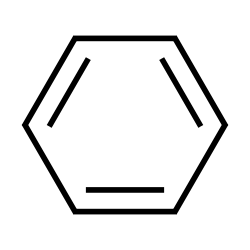
Some of the most important information of a molecule can be extracted based on its SMILES representation by using a number of different python packages. Thus, it's import to ensure that they are both valid, i.e., contain only valid characters, and unique, meaning that each molecule must have a unique representation. This requires a detailed **data wrangling** process.

2. **Use a suitable molecule representation**: Machine learning algorithms can speed up the process of identifying molecule's properties or even designing novel molecules with desirable properties [5]. This can have enormous consequences on many fields, such as the development of new materials for batteries and solar panels, or the sinthesis of new and more reliable drugs. However, to achieve such goal it's important to use a molecule representation that capture most of its inate properties and can also be easily fed to a machine learning. There are a number of different representantions and the the most common are shown in Figure 2.

**Figure 2** - Different representations of a molecule
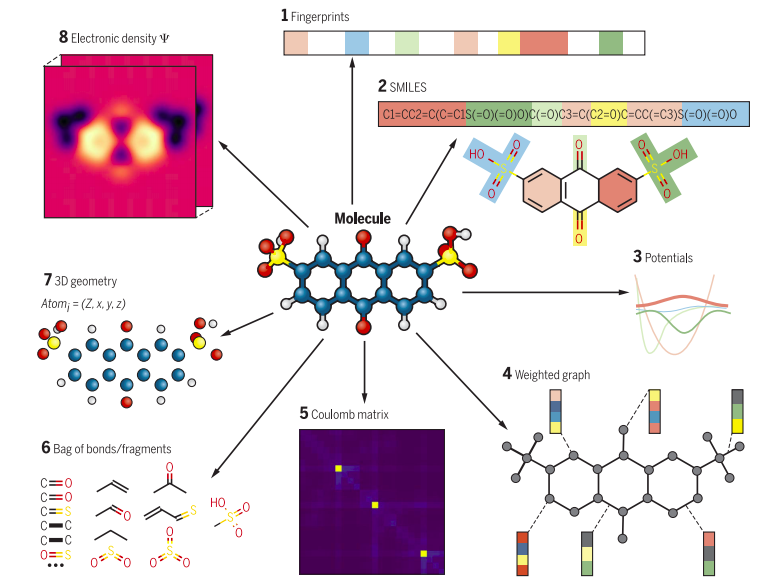

Two representations were chosen: **molecule descriptors** and the **coulomb matrix**, each of which will be discussed later.

### 3. Data wrangling and exploratory data analysis - Ensuring SMILES validity and better understanding the dataset

**3.1 - Data wrangling**


Here, the qm9 dataset will be further explored to ensure not only the SMILES validity, but also to better describe and understand the properties and features of each molecule. The first step is to install the required libraries:
* **RDKit** - The RDKit is a collection of cheminformatics and machine-learning software written in C++ and Python which is mainly used for extracting informations of a molecule based on its SMILES representation;
* **mordred** - It's a molecule descriptor calculator. The mordred can be used to calculated 1613 descriptors. A molecule descriptor can ultimately be viewed as a numerical representation of molecules' properties that are generated by algorithms. Thus, they can be used as input in a machine learning model.
* **molml** - A [library](https://pypi.org/project/molml/) to interface molecules and machine learning. The goal of this library is to be a simple way to convert molecules into a vector representation for later use with libraries such as scikit-learn.

In [11]:
# instaling the rdkit for molecule manipulation and visualization
#!conda install -y -c rdkit rdkit

In [12]:
# Installing mordred for molecular descriptors

!conda install -y -c rdkit -y -c mordred-descriptor mordred

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [13]:
! pip install molml

In [1]:
import os
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
from mordred import Calculator, descriptors  # To calculate descriptors
from molml.features import CoulombMatrix  # To calculate the coulomb matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [2]:
# Checking the number of XYZ files
directory = './QM9_xyz/'
len(os.listdir(directory))

133885

There are 133885 XYZ archives, each containing information about a specific molecule.

In [3]:
# Reading a file for visualization
file = os.listdir(directory)[0]
with open(directory+file, 'r') as f:
    content = f.readlines()

for line in content:
    print(line)

17

gdb 35176	3.69951	1.23093	1.09709	5.0509	78.3	-0.2676	0.0141	0.2818	1120.8417	0.137571	-380.797809	-380.79051	-380.789566	-380.829714	28.666	

N	-0.1158211823	-1.1588814083	 0.0253875797	-0.33752

C	-0.0634755918	-0.0038135736	 0.037200671	 0.335786

C	 0.0110718662	 1.4360892201	 0.0060552095	-0.351511

N	 0.5872156127	 2.0980870138	 1.2241547256	-0.40181

C	 1.3066483466	 2.1572458324	-0.0191184789	 0.488704

C	 2.7569832432	 1.7502741759	-0.3116380498	-0.12094

C	 2.4855003157	 2.2287618766	-1.7724735543	-0.215041

C	 1.8365633238	 3.3230156624	-0.8677898469	-0.150471

C	 3.1222090314	 3.2335825367	 0.0190305135	-0.223719

H	-0.8402848187	 1.9119567184	-0.4739629271	 0.133233

H	 0.0720428663	 2.9567193044	 1.4093287021	 0.24383

H	 3.2686458366	 0.8463850226	 0.0131731084	 0.100189

H	 3.3646646552	 2.5453426122	-2.3375094804	 0.102145

H	 1.8106735614	 1.6191840124	-2.3774773862	 0.106847

H	 1.2994311493	 4.2188724372	-1.1813921281	 0.081344

H	 3.0295061775	 3.5421096693	 1.

Information about what each row represents can be seen in Table 1. To further reach the goal of this project, not all information of the XYZ files is needed. Only the scalar properties, the atoms and its cartesian coordenates and the SMILES representation will be extracted. Using RDKit, it is easy to graph a molecule by its SMILES string, as can be seeing below.

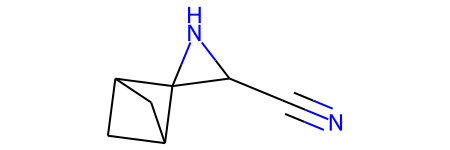

In [4]:
smile_example = Chem.MolFromSmiles(content[17 + 3].split()[0])
smile_example

First, let's read the entire qm9 dataset.

In [5]:
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []

    with open(path, 'r') as file:
        lines = file.readlines()
        n_atoms = int(lines[0])  # the number of atoms
        smile = lines[n_atoms + 3].split()[0]  # smiles string
        prop = lines[1].split()[2:]  # scalar properties
        
        # to retrieve each atmos and its cartesian coordenates
        for atom in lines[2:n_atoms + 2]:
            line = atom.split()
            # which atom
            atoms.append(line[0])

            # its coordinate
            # Some properties have '*^' indicading exponentiation 
            try:
                coordinates.append(
                    (float(line[1]),
                     float(line[2]),
                     float(line[3]))
                    )
            except:
                coordinates.append(
                    (float(line[1].replace('*^', 'e')),
                     float(line[2].replace('*^', 'e')),
                     float(line[3].replace('*^', 'e')))
                    )
                    
    return atoms, coordinates, smile, prop

In [6]:
# Reads the xyz files and return the properties, smiles and coordinates
data = []
smiles = []
properties = []
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    atoms, coordinates, smile, prop = read_xyz(path)
    data.append((atoms, coordinates)) # A tuple with the atoms and its coordinates 
    smiles.append(smile) # The SMILES representation
    properties.append(prop) # The molecules properties

The properties and the SMILES strings will be organized in dataframe. The ```data``` object contains the atoms and its cartesian coordinates for each molecule and they will be later used for the calculations of the coulomb matrix.

In [7]:
properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
df = pd.DataFrame(properties, columns = properties_names).astype('float32')
df['smiles'] = smiles
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N


The easiest way to check for inconsistencies in the SMILES representation of a molecule is to simply read it using RDKit. Should the representation presents an error, the [RDKIT should be unable to properly read its content](https://www.rdkit.org/docs/GettingStartedInPython.html), therefore returning a None value.

In [8]:
# Reading each molecule by its SMILES string
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [9]:
# Checking if there are None values
df['mol'].isnull().sum()

0

Surprisingly, all molecules were successfully read by the RDKIT package. As a first approach, this may not represent an issue, but for future developments it would be important to check if this result is solid. Let's now visualize some of the molecules.

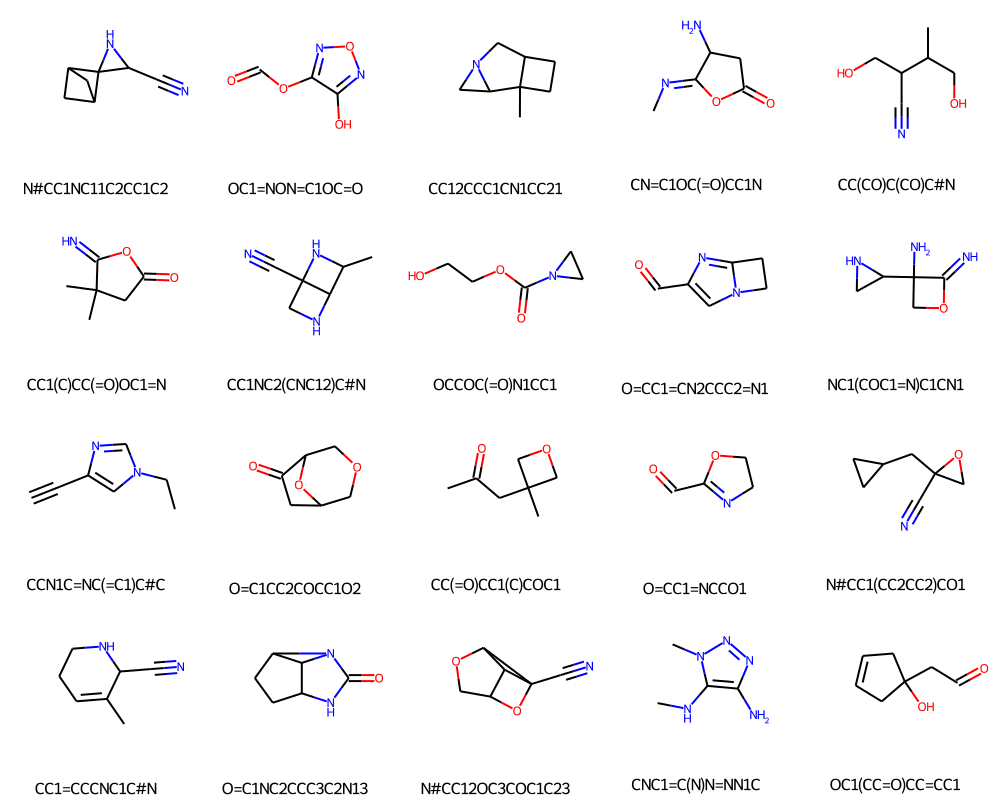

In [10]:
# Reads and prints the 20 first molecules
mol = df['mol'][:20]

Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))

Notice that the SMILES representation does not shows the hidrogen atoms, as they are implied by the rest of the molecules. However, counting the number of atoms using RDKit will return the wrong number of atoms. For example, let's consider just the first molecule.

In [11]:
df['mol'][0].GetNumAtoms()

9

It returns 9, which is the exact number of molecules seeing in its SMILES representation: OC1CCCC(=O)C1=O, where the number 1 represents the beginning and the end of rind bound structures. However, the total number of atoms in this molecule is 17, as can be seen in the "data" object that contains the atoms of a molecule and its coordinates. 

In [12]:
data[0]

(['N',
  'C',
  'C',
  'N',
  'C',
  'C',
  'C',
  'C',
  'C',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H'],
 [(-0.1158211823, -1.1588814083, 0.0253875797),
  (-0.0634755918, -0.0038135736, 0.037200671),
  (0.0110718662, 1.4360892201, 0.0060552095),
  (0.5872156127, 2.0980870138, 1.2241547256),
  (1.3066483466, 2.1572458324, -0.0191184789),
  (2.7569832432, 1.7502741759, -0.3116380498),
  (2.4855003157, 2.2287618766, -1.7724735543),
  (1.8365633238, 3.3230156624, -0.8677898469),
  (3.1222090314, 3.2335825367, 0.0190305135),
  (-0.8402848187, 1.9119567184, -0.4739629271),
  (0.0720428663, 2.9567193044, 1.4093287021),
  (3.2686458366, 0.8463850226, 0.0131731084),
  (3.3646646552, 2.5453426122, -2.3375094804),
  (1.8106735614, 1.6191840124, -2.3774773862),
  (1.2994311493, 4.2188724372, -1.1813921281),
  (3.0295061775, 3.5421096693, 1.06234023),
  (4.0399128268, 3.6114038773, -0.4376163482)])

The atoms and its order matchs its SMILES string, except the hidrogen atoms, which were not accounted. One workaround it's just to use the RDKit to count the number of hidrogen atoms and incorporate it in each molecule object as follows.

In [13]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

In [14]:
# Now checking the number of atoms of the first molecule
df['mol'][0].GetNumAtoms()

17

The molecules now have the right number of atomic especies. Thus, the total number of atoms and the total number of heavy atoms can be extracted as follows.

In [15]:
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [16]:
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2,<rdkit.Chem.rdchem.Mol object at 0x7fb362109f80>,17,9
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O,<rdkit.Chem.rdchem.Mol object at 0x7fb362109f30>,11,9
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e030>,22,9
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e080>,17,9
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e0d0>,20,9


Now, it is important to create a canonical SMILE representation for each molecule. Finding a canonical ordering of the atoms in a molecule is a prerequisite for generating a unique representation of the molecule [6]. Luckily, the RDKit has a module that does the job in a quite straightforward way. One only needs to read the SMILES representation of the molecule using the module ```Chem.MolFromSmiles```, as done before, and then transform it back again on SMILES representation using the module ```Chem.MolToSmiles```, ensuring that the parameters ```isomericSmiles``` and ```canonical``` are both set to be True.

In [17]:
def canonize(mol):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

canon_smile = []
for molecule in smiles:
    canon_smile.append(canonize(molecule))
    
df['canon_smiles'] = canon_smile

In [18]:
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2,<rdkit.Chem.rdchem.Mol object at 0x7fb362109f80>,17,9,N#CC1NC12C1CC2C1
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O,<rdkit.Chem.rdchem.Mol object at 0x7fb362109f30>,11,9,O=COc1nonc1O
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e030>,22,9,CC12CCC1CN1CC12
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e080>,17,9,CN=C1OC(=O)CC1N
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x7fb36210e0d0>,20,9,CC(CO)C(C#N)CO


It is possible to note small changes on the SMILES ordering for some molecules. Now, it's important to look for duplicates in the canonical SMILES representation. The standard SMILES representations allows for different representations of the same molecule depending on the chosed starting atom. For example, let's take a look into a molecule with a rather easy representation.  

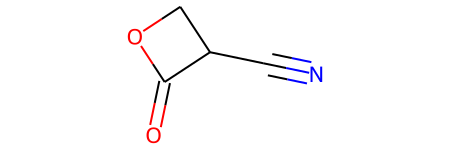

In [19]:
Chem.MolFromSmiles('O=C1OCC1C#N')

From its SMILES representation, O=C1OCC1C#N, it's possible to infer that the atom of oxygen with two bonds (O=) at the bottom of the image was the starting point. The edges of the graph represents an atom of carbon unless it is specified otherwise. The next atom is, therefore, an atom of carbon, forming the sequence O=C. The counting then goes left to the next oxygen atom, followed by the carbon atom at the top and the carbon at the right edge of square graph. Finally, the last carbon is bounded with the nitrogen atom, forming the SMILES representation O=COCCC#N, where the symbol # represents a triple bound between two atoms. The only missing symbol is the number 1. The numbers on a SMILES string represents a ring structure. Thus, the ring structure starts at the first counted carbon atom (O=C1) and finishes in the carbon at the right edge of the square graph, which produces the O=C1OCC1C#N SMILES.<br>
Now, one can set the starting point on each and every atom of this molecule and still get a valid representation. Starting at the nitrogen atom, an analogous SMILES would be N#CC1COC1=O, as can be seem below. The molecule is still the same, just flipped 90 degrees horizontally.

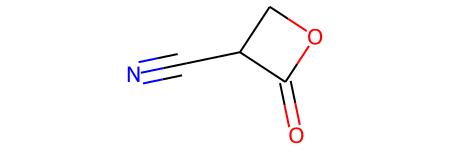

In [20]:
Chem.MolFromSmiles('N#CC1COC1=O')

Now, let's check if there are duplicated canonical SMILES. 

In [21]:
df['canon_smiles'][df['canon_smiles'].duplicated()]

17903             NC=Nc1cnccn1
24934             Cc1cnc(F)cn1
27909            CN(C)c1cnccn1
28007     O=[N+]([O-])c1cnccn1
30292          c1cnc(N2CC2)cn1
                  ...         
131653           CC(C)c1cnccn1
132483           CNc1cnc(F)cn1
133438          C#Cc1cnc(O)cn1
133655          N#Cc1cnc(O)cn1
133850          C#Cc1cnc(N)cn1
Name: canon_smiles, Length: 87, dtype: object

There are 87 repeated canonical SMILES. This means that there are different SMILES strings representing the same molecule. To ensure it, let's visualize a few of these molecules and its properties.

In [22]:
df[df['canon_smiles'] == 'COc1cnccn1']

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
36165,5.39096,1.66577,1.28282,1.6581,67.309998,-0.2413,-0.0421,0.1992,902.531799,0.109364,-378.768066,-378.761414,-378.760468,-378.799072,24.305,COC1=NC=CN=C1,<rdkit.Chem.rdchem.Mol object at 0x7fb35245b3a0>,14,8,COc1cnccn1
63934,5.39096,1.66577,1.28282,1.6581,67.309998,-0.2413,-0.0421,0.1992,902.531799,0.109364,-378.768066,-378.761414,-378.760468,-378.799072,24.305,COC1=CN=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7fb341f46990>,14,8,COc1cnccn1


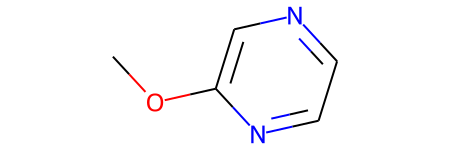

In [23]:
Chem.MolFromSmiles('COC1=CN=CC=N1')

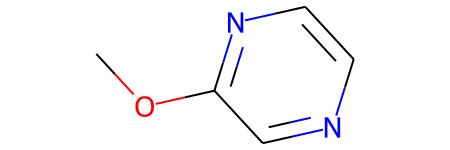

In [24]:
Chem.MolFromSmiles('COC1=NC=CN=C1')

Properties' values are indeed the same and drawing the molecules actually helps to understand the reason. The only difference between the molecules are the placements of the nitrogen atoms. Such difference had no impact on the molecules's properties and, as such, they will be dropped from the dataframe.

In [25]:
# Index of the duplicated rows
ind = df.index[df['canon_smiles'].duplicated()]
df = df.drop(ind)

Now, a new mol object will be created taking into account the canonical SMILES representation, as a way to ensure that subsequent procedures will be performed using a correct and unique representation. 

In [26]:
df['mol'] = df['canon_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

As a final step in the data wrangling process, properties outliers will be evaluated.

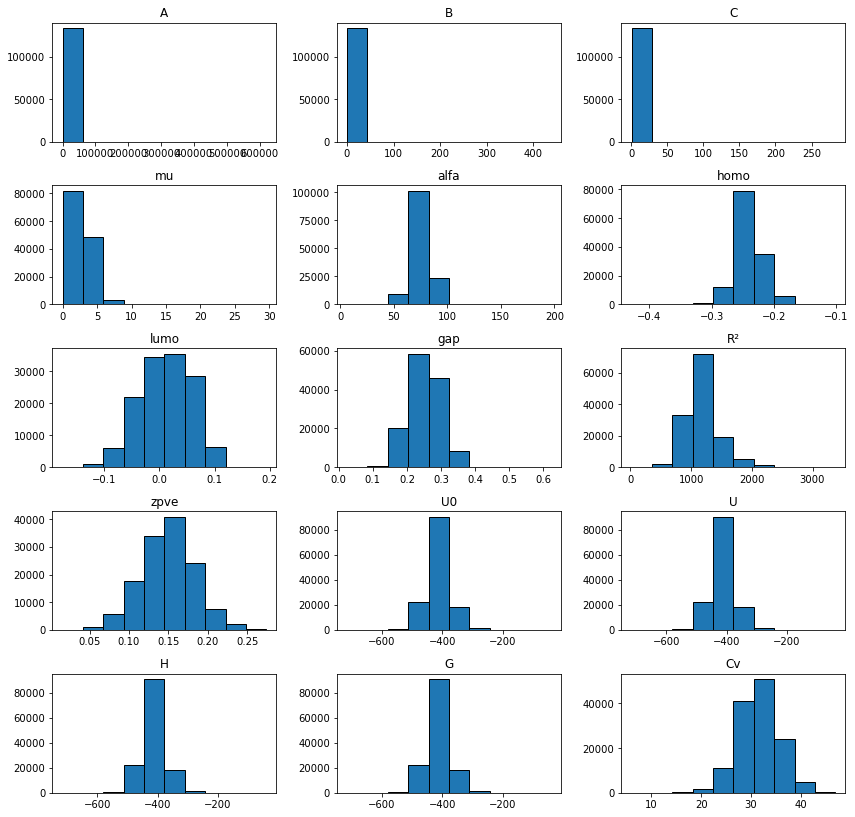

In [27]:
plt.figure(figsize=(12, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()

In [28]:
df.describe()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,num_of_atoms,num_of_heavy_atoms
count,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000
mean,9.817750,1.406112,1.124983,2.706031,75.192825,-0.239977,0.011164,0.251141,1189.569214,0.148550,-411.537964,-411.529449,-411.528473,-411.571320,31.603436,17.986069,8.795886
std,1810.053833,1.584265,1.095953,1.530345,8.187228,0.022133,0.046923,0.047507,279.796112,0.033264,40.056843,40.056622,40.056622,40.057354,4.061663,2.953332,0.508952
min,0.000000,0.337120,0.331180,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,-714.568054,-714.560181,-714.559204,-714.602112,6.002000,3.000000,1.000000
25%,2.554310,1.091790,0.910563,1.588800,70.379997,-0.252500,-0.023800,0.216300,1018.340546,0.125308,-437.913811,-437.905693,-437.904755,-437.947525,28.945000,16.000000,9.000000
50%,3.089935,1.370030,1.078720,2.500050,75.500000,-0.241000,0.012000,0.249500,1147.573181,0.148341,-417.864075,-417.856445,-417.855499,-417.895630,31.556999,18.000000,9.000000
75%,3.834450,1.653957,1.279640,3.635900,80.519997,-0.228700,0.049200,0.288200,1308.888245,0.171158,-387.049057,-387.039703,-387.038757,-387.083221,34.278000,20.000000,9.000000
max,619867.687500,437.903870,282.945465,29.556400,196.619995,-0.101700,0.193500,0.622100,3374.753174,0.273944,-40.478931,-40.476063,-40.475117,-40.498596,46.969002,29.000000,9.000000


Rotational constant A seems to have some outliers, as the maximum value is much greater than the mean. Although rotational constants B and C also seem to also have outliers, values of these properties can [hugely vary](http://www.colby.edu/chemistry/PChem/scripts/ABC.html), going from 11 GHz (Rotational constant A) for the ozone molecule, to as high as 816.68 GHz (Rotational constant C) for the water molecule.

In [29]:
# Checking for unusual values
df[df['A'] > 100]

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
18411,159.871170,0.379330,0.379330,1.9087,143.529999,-0.2266,-0.0676,0.1589,2708.153809,0.085798,-345.074463,-345.064758,-345.063812,-345.108856,33.347000,CC#CC#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x7fb329964300>,13,9,C#CC#CC#CC#CC
20530,159.619873,0.782570,0.782570,6.3203,82.739998,-0.2665,-0.0718,0.1947,1344.432739,0.065892,-285.016357,-285.009094,-285.008148,-285.047272,23.785999,CC#CC#CC#N,<rdkit.Chem.rdchem.Mol object at 0x7fb32998e8f0>,10,7,CC#CC#CC#N
21521,159.934586,0.783440,0.783440,1.5732,92.339996,-0.2323,-0.0452,0.1871,1373.624756,0.075867,-268.917908,-268.910156,-268.909241,-268.949005,26.267000,CC#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x7fb3299a2620>,11,7,C#CC#CC#CC
23642,159.655106,0.377100,0.377100,7.3662,130.860001,-0.2540,-0.0911,0.1628,2674.166504,0.076809,-361.170929,-361.161896,-361.160950,-361.205109,29.965000,CC#CC#CC#CC#N,<rdkit.Chem.rdchem.Mol object at 0x7fb3299cccb0>,12,9,CC#CC#CC#CC#N
26443,619867.687500,1.334550,1.334540,0.0151,72.389999,-0.2465,-0.0565,0.1900,802.148499,0.046718,-229.615448,-229.609222,-229.608276,-229.639954,21.875000,C#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x7fb329a04cb0>,8,6,C#CC#CC#C
62612,127.834969,24.858721,23.978720,1.5258,16.969999,-0.2653,0.0784,0.3437,83.793999,0.051208,-115.679138,-115.675819,-115.674873,-115.701874,8.751000,CO,<rdkit.Chem.rdchem.Mol object at 0x7fb32d414d00>,6,2,CO
62814,160.280411,8.593230,8.593210,0.7156,28.780001,-0.2609,0.0613,0.3222,177.196304,0.055410,-116.609550,-116.605553,-116.604607,-116.633774,12.482000,CC#C,<rdkit.Chem.rdchem.Mol object at 0x7fb32d418da0>,7,3,C#CC
71061,159.035675,9.223270,9.223240,3.8266,24.450001,-0.3264,0.0376,0.3640,160.722305,0.045286,-132.718155,-132.714569,-132.713623,-132.742142,10.287000,CC#N,<rdkit.Chem.rdchem.Mol object at 0x7fb32d4bd990>,6,3,CC#N
79580,285.488403,38.982300,34.298920,2.1089,14.180000,-0.2670,-0.0406,0.2263,59.989101,0.026603,-114.483612,-114.480743,-114.479805,-114.505264,6.413000,C=O,<rdkit.Chem.rdchem.Mol object at 0x7fb33f5a7df0>,4,2,C=O
87471,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316000,N,<rdkit.Chem.rdchem.Mol object at 0x7fb34f1c5940>,4,1,N


Indeed, the molecules with ID 9492 and 31832 have values for the rotational constant A that are far above the mean value for such property. They will be dropped. As explained above, even though some values of the rotational constants seem to be outliers, they are within a reasonable range of values and, therefore, will be left untoched. 

In [30]:
df = df.drop([9492, 31832])

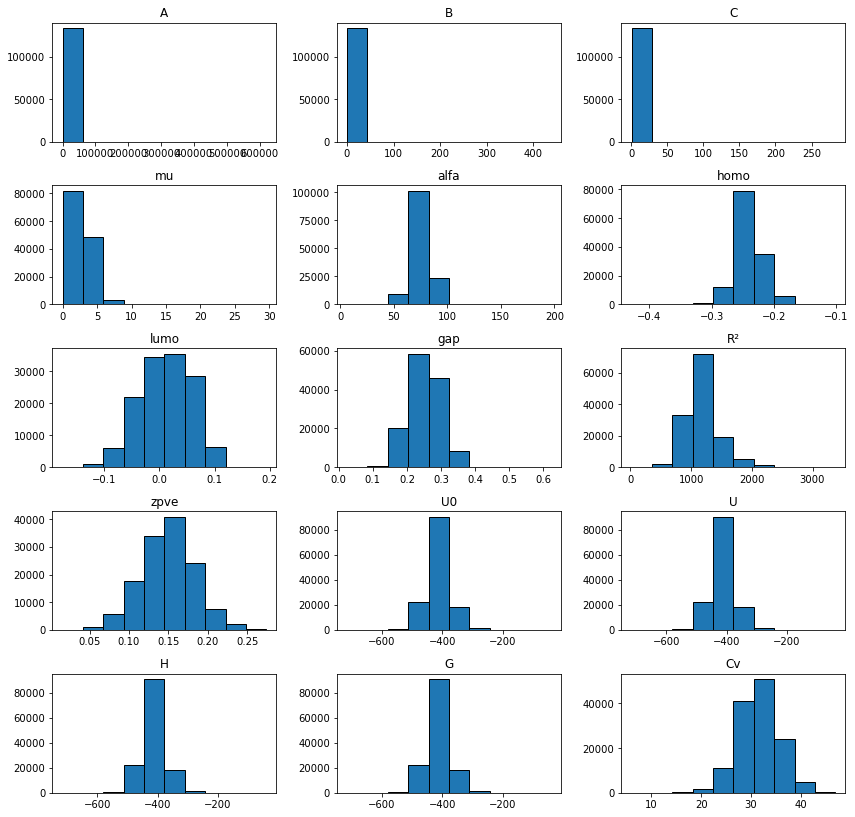

In [31]:
plt.figure(figsize=(12, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()

In [32]:
# Saving the final dataframe
df.to_csv('qm9_kaggle.csv')

The data wrangling process ends here. It was somehow easier than first expected as the dataset was well structured from the beginning. Further analysis are welcomed to ensure that the python packages employed to read, extract and manipulate the data did in fact work as planned and all the information up until this point is valid and can be used to make properties prediction.

**3.2 Exploratory data analysis**

The following question will allow a better understanding of the qm9 dataset properties as a whole.
1. What are the main clusters according to the atomic number?
2. How are the properties distributed in these clusters?
3. What is the distribution of heavy atoms in each molecule?
4. How are the properties distributed according to the number of heavy atoms?
5. What molecular descriptors can be used to represent the molecules?
6. What type of molecular descriptors yelds the best property prediction?

**3.2.1 What is the frequency of molecules according to their atomic number?**

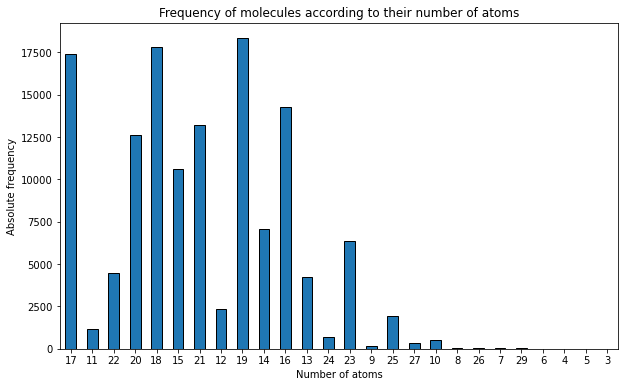

In [32]:
df['num_of_atoms'].value_counts(sort=False).plot.bar(figsize=(10,6), 
                                                     title="Frequency of molecules according to their number of atoms", 
                                                     xlabel='Number of atoms',
                                                     ylabel='Absolute frequency',
                                                     rot=0,
                                                     edgecolor='k')
plt.show()

The frequency of the molecules according to the number of atoms loosely follows a normal distribution, with molecules containing 17, 18 and 19 atoms being predominant. Each of these cluster could probably be used for further machine learning model benchmark, as an alternative for using the whole dataset. 

**3.2.2 How are the properties distributed in these clusters?**

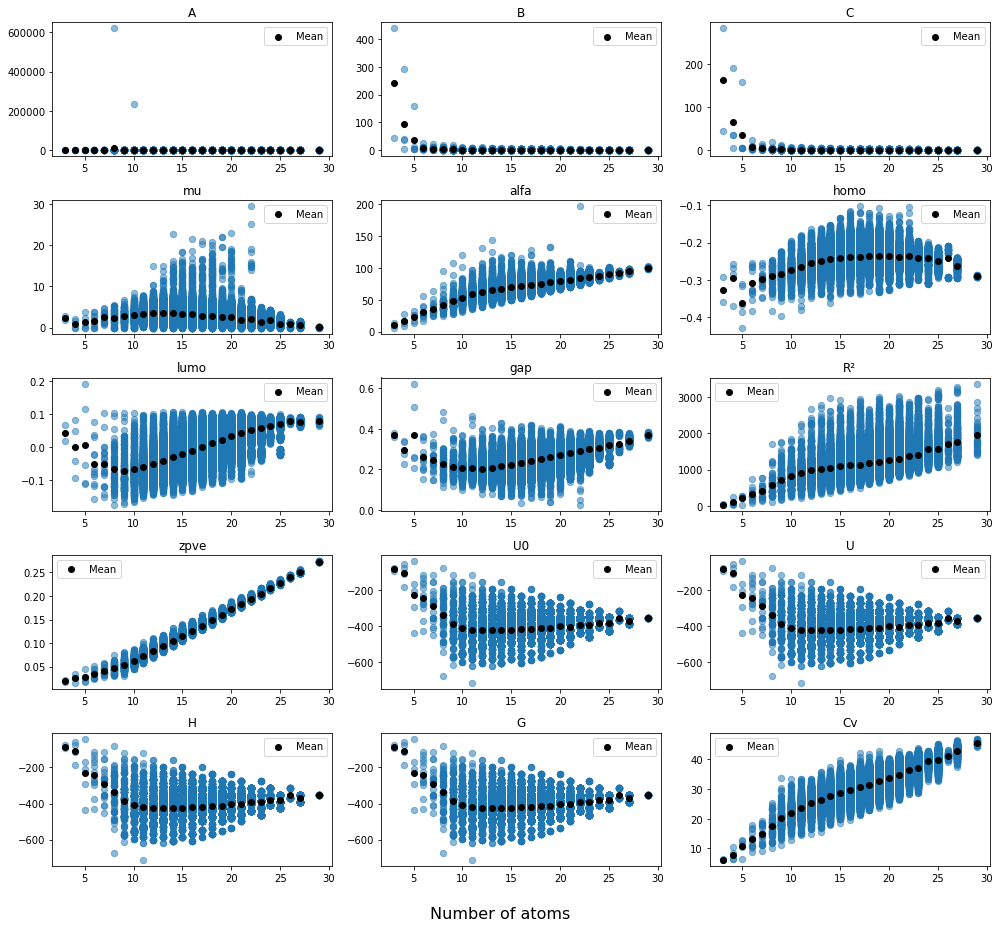

In [33]:
plt.figure(figsize=(14,20))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.scatter(df['num_of_atoms'], df[prop], s=40, alpha=0.5)
    
    for atom in np.unique(df['num_of_atoms']):
        plt.scatter(atom, df[prop][df['num_of_atoms'] == atom].mean(), c='k', label='Mean')
        
    # Dictionaries can't have duplicated keys
    # This prevents repeated legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(prop)
    plot_counter = plot_counter + 1
    
plt.suptitle('Number of atoms', x=.5, y=0.35, ha='center', size=16) 
plt.tight_layout()
plt.show()

There are some very interesting results:
* zpve ([zero-point vibrational energy](https://www.britannica.com/science/zero-point-energy)): It represents the lowest possible energy a quantum system may have. Thus, it makes sense that the more atoms a molecule has, the more its vibrational energy would be. However, it's interesting to note that the relationship between this property and the number of atoms is almost linear.
* Cv ([heat capacity](https://www.britannica.com/science/heat-capacity) at 298.15 K): It's the amount of heat per unit mass that is required to raise the temperature by 1°C. Its value also grows with the number of atoms in a molecule in almost a linear fashion.
* Uo, U, H and G (internal energy at 0 K, internal energy at 298.15 K, enthalpy at 298.15 K, free energy at 298.15 K): They all follow the same behavior and visually, it could be argue that their values are virtually the same, as can also be seen on the histogram presented earlier.

It's also important to note two things. First, the variance of the properties seems to decrease the more atoms a molecule has. This could result in better properties predictions. However, this can be a simple consequence of the fact that molecules with 20 atoms or more are far more rare in the dataset. Second, using molecules with only a specific number of atoms might not be representative when using machine learning algorithms for property predictions, as the values of some properties can greatly vary with the total number of atoms. 

**3.2.3 What is the distribution of heavy atoms in each molecule?**

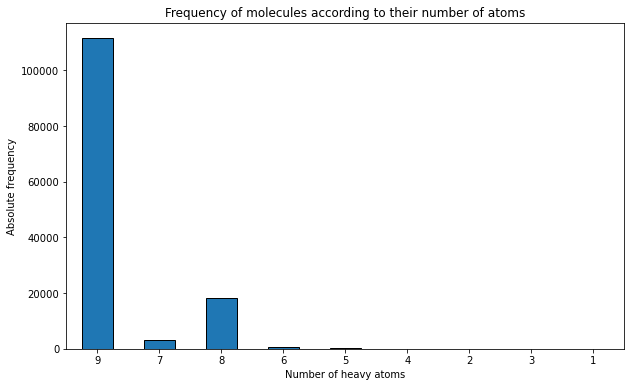

In [34]:
df['num_of_heavy_atoms'].value_counts(sort=False).plot.bar(figsize=(10,6), 
                                                     title="Frequency of molecules according to their number of atoms", 
                                                     xlabel='Number of heavy atoms',
                                                     ylabel='Absolute frequency',
                                                     rot=0,
                                                     edgecolor='k')
plt.show()

The majority of molecules have 9 heavy atoms in its composition. If later analysis prove to be problematic due to atoms with lower number of heavy atoms, it might be safe to just exclude such molecules.

**3.2.4 How are the properties distributed according to the number of heavy atoms?**

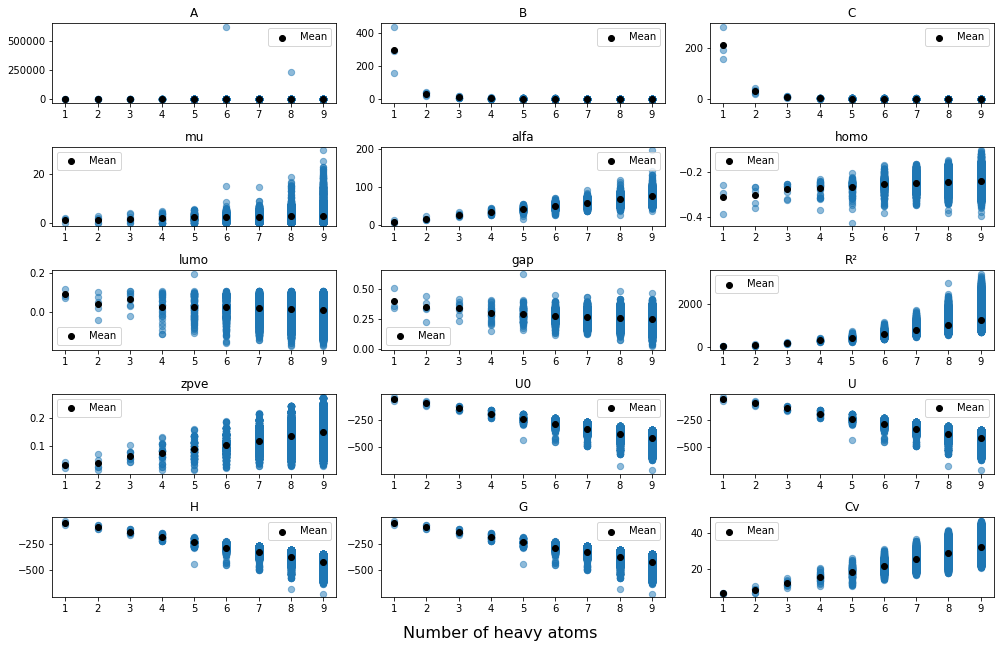

In [35]:
plt.figure(figsize=(14,14))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.scatter(df['num_of_heavy_atoms'], df[prop], s=40, alpha=0.5)
    
    for atom in np.unique(df['num_of_heavy_atoms']):
        plt.scatter(atom, df[prop][df['num_of_heavy_atoms'] == atom].mean(), c='k', label='Mean')
        
    # Dictionaries can't have duplicated keys
    # This prevents repeated legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(prop)
    plot_counter = plot_counter + 1
    
plt.suptitle('Number of heavy atoms', x=.5, y=0.35, ha='center', size=16) 
plt.tight_layout()
plt.show()

The overall behavior of the properties when considering only the heavy atoms of a molecule follows, to some extent, the same behavior as seen before. Some properties' values grows with the number of heavy atoms, while some decrease and some appears to remain somewhat constant.

**3.2.5 What molecular descriptors can be used to represent the molecules?**

Molecule descriptors can be thought of as a mathematical representations of molecules' properties that are generated by algorithms. The numerical values of such descriptors are used to quantitatively describe the physical and chemical information of the molecules [7]. They can be divided as experimental measurements and theoretical molecular descriptors, which are derived from a symbolic representation of the molecule. Hence the importance to ensure SMILES valid and uniqueness. In this sense, the properties of the molecules from the qm9 dataset can be seen as descriptors. Thus, we will be using properties calculated from the SMILES strings to predict known properties of the qm9 molecules. However, due to memory issues, only the molecules with 19 atoms will be considered at first for the descriptors calculation.

In [70]:
# Using only the molecules with 19 atoms
calc = Calculator(descriptors, ignore_3D=True)
df_desc = calc.pandas(df['mol'][df['num_of_atoms']==19])

# Saving the resulting file 
df_desc.to_csv('descriptors.csv')

100%|█████████████████████████████████████| 18333/18333 [51:46<00:00,  5.90it/s]


In [102]:
df_desc = pd.read_csv('descriptors.csv')

/Users/yangyang/miniforge3/envs/alfabet/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (830,846,866,867,868,869,870,871,872,873,874,875,876,877,878,879) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
df_desc.info()

NameError: name 'df_desc' is not defined

In [104]:
df_desc.loc[:, df_desc.dtypes == np.object]

/Users/yangyang/miniforge3/envs/alfabet/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,AATS6dv,AATS7dv,AATS8dv,AATS6d,AATS7d,AATS8d,AATS6s,AATS7s,AATS8s,AATS6Z,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.25,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.5,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),0.33333333333333337,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
1,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,4.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,4.5,...,float division by zero (MDEC-44),0.25,float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
2,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),1.1447142425533319,float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
3,0.0,0.0,invalid value encountered in double_scalars (A...,1.4,1.0,invalid value encountered in double_scalars (A...,2.0,1.0,invalid value encountered in double_scalars (A...,6.2,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
4,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,...,1.0,float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18328,0.8695652173913043,0.0,0.0,1.5217391304347827,1.1333333333333333,1.0,2.36231884057971,2.4,1.0,7.6521739130434785,...,float division by zero (MDEC-44),0.19999999999999996,0.8164965809277259,float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
18329,0.0,0.0,invalid value encountered in double_scalars (A...,1.0,1.0,invalid value encountered in doub

There are a huge number of columns which are failed attempts to generate a descriptor. They will be deleted and there rest will be set as float32.

In [73]:
df_desc = df_desc.select_dtypes(include=np.number).astype('float32')

In [74]:
# Removing columns with variance = 0
df_desc = df_desc.loc[:, df_desc.var() > 0.0]

In [75]:
# Normalizing the descriptors
df_descN = pd.DataFrame(MinMaxScaler().fit_transform(df_desc), columns = df_desc.columns)

In [76]:
# Selecting the initial properties for molecules with only 19 atoms
df_19 = df[df['num_of_atoms']==19]

In [77]:
df_19.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
15,2.12489,1.63436,1.10042,4.6856,81.629997,-0.2403,0.0032,0.2435,1156.454102,0.161057,-382.092560,-382.083923,-382.082977,-382.125854,32.577999,CC1=CCCNC1C#N,<rdkit.Chem.rdchem.Mol object at 0x7ff6027a6bc0>,19,9,CC1=CCCNC1C#N
19,3.38306,1.05223,0.98114,3.3760,76.389999,-0.2415,-0.0172,0.2243,1260.563354,0.157678,-423.046265,-423.037292,-423.036346,-423.080780,33.416000,OC1(CC=O)CC=CC1,<rdkit.Chem.rdchem.Mol object at 0x7ff6027a4300>,19,9,O=CCC1(O)CC=CC1
25,2.63356,1.47854,1.27617,2.5519,70.519997,-0.2467,0.0819,0.3286,1076.151855,0.158115,-460.140991,-460.132294,-460.131348,-460.175049,32.082001,CC1(OCCO1)C1CO1,<rdkit.Chem.rdchem.Mol object at 0x7ff6027a4da0>,19,9,CC1(C2CO2)OCCO1
26,4.47045,0.98693,0.95069,1.4657,80.059998,-0.2394,0.0508,0.2902,1327.052734,0.163629,-327.883575,-327.874023,-327.873077,-327.919342,33.543999,CC#CCC1(C)CN1,<rdkit.Chem.rdchem.Mol object at 0x7ff6027a4c10>,19,8,CC#CCC1(C)CN1
31,2.49766,2.11873,1.50602,1.2433,77.300003,-0.2224,0.0887,0.3111,948.676025,0.159213,-385.845642,-385.838074,-385.837128,-385.877136,30.826000,CC12OC3C4C3C1(C)C24,<rdkit.Chem.rdchem.Mol object at 0x7ff5fcfb8490>,19,9,CC12OC3C4C3C1(C)C42


In [78]:
np.shape(df_descN)

(18333, 1069)

Now, the property predictions can be done in a very straightforward way. Such task will be performed by a simple mlp network with two hidden layers and the same number of neurons on each layer. The number of neurons can be set when calling the ```neural_model``` function. The k-fold cross validation method, with k=5, will also be used to reduce the chances of overfitting. Lastly, the mean squared error will be evaluated for each fold and its mean will represent the accuracy of the model.

**3.2.6 What type of molecular descriptors yelds the best property prediction?**

In [79]:
# Testing with the "mu" (dipole moment) property
x_train, x_test, y_train, y_test = train_test_split(df_descN, df_19['mu'], 
                                                    test_size=0.2, random_state=42)

In [36]:
def neural_model(x, y, x_test, y_test, neurons):
    """
    Neural network model
    
    Inputs
    x: descriptors values for training and validation
    y: properties values for training and validation
    x_test: descriptors values for test
    y_test: properties values for test
    
    
    Outputs
    model: trained neural network model
    score: a list with the score values for each fold
    """
    np.random.seed(1)
    score = []
    kfold = KFold(n_splits=5, shuffle=True)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mean_absolute_error'])

    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10)
        
    for train, validation in kfold.split(x, y):

        model.fit(x.iloc[train], y.iloc[train], 
                      epochs=100,
                      batch_size=128,
                      callbacks=[rlrop],
                      verbose=0,
                      validation_data=(x.iloc[validation], y.iloc[validation]))

        score.append(model.evaluate(x_test, y_test))
    
    return model, score

In [81]:
model, score = neural_model(x_train, y_train, x_test, y_test, neurons=64)

KeyboardInterrupt: 

In [50]:
print(f'mse: {np.mean(score):.3f} \u00B1 {np.std(score):.3f} ')

mse: 0.592 ± 0.041 


# Testing with "H" column (part of data)

In [51]:
# Testing with the "H" (dipole moment) property
x_train_H, x_test_H, y_train_H, y_test_H = train_test_split(df_descN, df_19['H'], 
                                                    test_size=0.2, random_state=42)

In [52]:
model, score = neural_model(x_train_H, y_train_H, x_test_H, y_test_H, neurons=64)

115/115 [==============================] - 0s 2ms/step - loss: 0.0678 - mean_absolute_error: 0.1949


In [53]:
print(f'mse: {np.mean(score):.3f} \u00B1 {np.std(score):.3f} ')

mse: 0.193 ± 0.136 


In [55]:
test_predictions = model.predict(x_test_H)
errors = y_test_H - test_predictions.flatten()

In [56]:
#MAE
MAE = np.abs(errors).mean()
MAE

0.19491845

In [67]:
# RMSE
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_test_H, test_predictions.flatten(), squared=False)
RMSE

0.2603183

In [66]:
# “reduce values” = RMSE/std dev of target data
reduce_values = RMSE / (df['H'].std())
reduce_values

0.006488284257851943

In [102]:
df['H'].std()

40.056602

In [65]:
# MAE/MAD
MAE / (df['H'].mad())

0.006287792147941703

# Learning Curve

In [38]:
np.random.seed(123)
chosen_idx = np.random.choice(len(df), replace=False, size=25000)
df_subset = df.iloc[chosen_idx]
df_subset.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
60829,3.14617,1.38222,1.24187,1.5348,80.900002,-0.2262,0.0771,0.3034,1119.441650,0.181751,-387.032806,-387.024353,-387.023407,-387.065643,33.512001,CC(C)C12CC3C(O1)C23,<rdkit.Chem.rdchem.Mol object at 0x7fa2d1a957b0>,21,9,CC(C)C12CC3C(O1)C32
127190,3.72127,1.61761,1.23969,1.8637,66.410004,-0.2466,-0.0142,0.2324,957.350891,0.117412,-399.718536,-399.711029,-399.710083,-399.750610,27.799000,ON=C1CCC11CO1,<rdkit.Chem.rdchem.Mol object at 0x7fa32ef43a30>,15,8,ON=C1CCC12CO2
82819,3.49677,0.77754,0.74424,4.3123,88.790001,-0.2588,0.0243,0.2831,1621.775879,0.167622,-366.018036,-366.006958,-366.006012,-366.055756,38.655998,CC#CC(C)(C)CC#N,<rdkit.Chem.rdchem.Mol object at 0x7fa2e668ce40>,20,9,CC#CC(C)(C)CC#N
105605,2.00491,1.45449,0.91750,2.5303,80.160004,-0.2434,-0.0219,0.2215,1299.114502,0.169225,-403.104584,-403.095245,-403.094299,-403.139740,33.756001,O=CC(C1CC1)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa312dd4210>,20,9,O=CC(C1CC1)N1CC1
116760,2.34612,1.00330,0.74283,3.6006,82.860001,-0.2806,0.0287,0.3093,1566.388428,0.192403,-404.368988,-404.358002,-404.357086,-404.405548,39.196999,CCC(C)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x7fa3278732b0>,22,9,CCC(C)C(C#N)CO


In [39]:
calc = Calculator(descriptors, ignore_3D=True)
df_desc_subset = calc.pandas(df_subset['mol'])

100%|█████████████████████████████████████| 25000/25000 [29:16<00:00, 14.23it/s]


In [40]:
df_desc_subset.to_csv('df_desc_subset.csv')

In [41]:
df_desc_subset.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
Int64Index: 25000 entries, 60829 to 70135
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(808), int64(325), object(478)
memory usage: 307.5+ MB


In [42]:
df_desc_subset.loc[:, df_desc_subset.dtypes == np.object]

/Users/yangyang/miniforge3/envs/alfabet/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,AATS3dv,AATS4dv,AATS5dv,AATS6dv,AATS7dv,AATS8dv,AATS3d,AATS4d,AATS5d,AATS6d,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
60829,0.816327,0.25,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.469388,1.833333,1.666667,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
127190,3.692308,2.380952,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.653846,1.809524,1.230769,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),0.25,float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
82819,1.72973,1.111111,0.96,0.178571,0.0,invalid value encountered in double_scalars (A...,1.891892,1.622222,1.2,1.107143,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
105605,2.536585,1.6,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.536585,2.15,1.444444,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
116760,1.607843,1.12963,0.217391,0.0,0.0,invalid value encountered in double_scalars (A...,1.901961,1.462963,1.152174,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41496,0.796296,0.705882,0.944444,0.888889,0.0,invalid value encountered in double_scalars (A...,1.851852,1.705882,1.805556,1.518519,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
129101,1.125,0.555556,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.21875,1.555556,1.142857,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
70961,2.674419,0.756098,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.209302,1.512195,1.0,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),0.25,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-

In [43]:
df_desc_subset = df_desc_subset.select_dtypes(include=np.number).astype('float32')

In [44]:
# Removing columns with variance = 0
df_desc_subset = df_desc_subset.loc[:, df_desc_subset.var() > 0.0]

In [45]:
# Normalizing the descriptors
df_desc_subsetN = pd.DataFrame(MinMaxScaler().fit_transform(df_desc_subset), columns = df_desc_subset.columns)

In [46]:
# make sure there is at least 20% of testing data
MAE_list = []
for i in range(50, 20000, 100):
    x_train, x_test, y_train, y_test = train_test_split(df_desc_subsetN, df_subset['H'], 
                                                    test_size=1-(i/25000), random_state=42)
    model, score = neural_model(x_train, y_train, x_test, y_test, neurons=64)
    test_predictions = model.predict(x_test)
    errors = y_test - test_predictions.flatten()
    MAE = np.abs(errors).mean()
    MAE_list.append(MAE)

2022-04-21 11:43:51.737377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


680/680 [==============================] - 2s 3ms/step - loss: 18.2085 - mean_absolute_error: 3.0711


580/580 [==============================] - 1s 2ms/step - loss: 0.3782 - mean_absolute_error: 0.4086


480/480 [==============================] - 1s 2ms/step - loss: 0.5747 - mean_absolute_error: 0.5097


377/377 [==============================] - 1s 2ms/step - loss: 0.4149 - mean_absolute_error: 0.4162


277/277 [==============================] - 1s 3ms/step - loss: 0.3194 - mean_absolute_error: 0.2940


174/174 [==============================] - 0s 2ms/step - loss: 0.8067 - mean_absolute_error: 0.6293


158/158 [==============================] - 0s 2ms/step - loss: 0.3658 - mean_absolute_error: 0.2405


In [57]:
traning_size = list(range(50, 20000, 100))

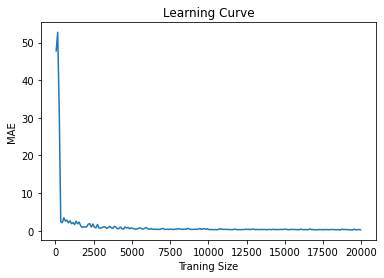

In [58]:
import matplotlib.pyplot as plt

plt.plot(traning_size, MAE_list)
plt.title('Learning Curve')
plt.xlabel('Traning Size')
plt.ylabel('MAE')
plt.show()

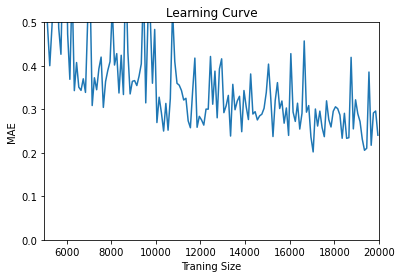

In [64]:
plt.plot(traning_size, MAE_list)
plt.title('Learning Curve')
plt.xlim([5000, 20000])
plt.ylim([0, 0.5])
plt.xlabel('Traning Size')
plt.ylabel('MAE')
plt.show()

# Using all data

In [37]:
# Using all the molecules
calc = Calculator(descriptors, ignore_3D=True)
df_desc_all = calc.pandas(df['mol'].iloc[:60000])

# Saving the resulting file 
#df_desc.to_csv('descriptors.csv')

100%|███████████████████████████████████| 60000/60000 [1:34:23<00:00, 10.59it/s]


In [38]:
len(df_desc_all)

60000

In [39]:
df_desc_all.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
Int64Index: 60000 entries, 0 to 60020
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(815), int64(325), object(471)
memory usage: 738.0+ MB


In [40]:
df_desc_all.loc[:, df_desc_all.dtypes == np.object]

/Users/yangyang/miniforge3/envs/alfabet/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,AATS3dv,AATS4dv,AATS5dv,AATS6dv,AATS7dv,AATS8dv,AATS3d,AATS4d,AATS5d,AATS6d,...,MDEC-44,MDEO-11,MDEO-12,MDEO-22,MDEN-11,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33
0,2.486486,1.642857,1.25,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.756757,2.0,1.375,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),0.333333,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
1,18.363636,10.2,13.714286,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,3.181818,2.6,1.714286,1.0,...,float division by zero (MDEC-44),0.2,1.298672,0.333333,float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),0.5,float division by zero (MDEN-23),float division by zero (MDEN-33)
2,0.864407,0.0625,0.0,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.576271,1.6875,1.117647,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
3,4.064516,2.28,0.315789,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.322581,1.92,1.473684,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),0.5,float division by zero (MDEO-22),float division by zero (MDEN-11),0.333333,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
4,2.177778,1.770833,1.470588,0.0,0.0,invalid value encountered in double_scalars (A...,1.933333,1.4375,1.088235,1.0,...,float division by zero (MDEC-44),0.2,float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60016,6.962963,2.173913,1.166667,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.0,1.826087,1.5,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),0.5,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33)
60017,2.333333,2.793103,2.470588,0.0,invalid value encountered in double_scalars (A...,invalid value encountered in double_scalars (A...,2.722222,2.068966,1.470588,1.0,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),0.333333,float division by zero (MDEN-23),float division by zero (MDEN-33)
60018,3.103448,0.896552,0.5,0.071429,0.0,0.0,2.517241,1.931034,2.0625,1.642857,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float division by zero (MDEO-22),float division by zero (MDEN-11),float division by zero (MDEN-12),float division by zero (MDEN-13),1.5,float division by zero (MDEN-23),float division by zero (MDEN-33)
60019,1.8,0.621622,0.333333,0.0,0.0,invalid value encountered in double_scalars (A...,2.622222,2.108108,1.703704,1.5,...,float division by zero (MDEC-44),float division by zero (MDEO-11),float division by zero (MDEO-12),float divisi

In [41]:
df_desc_all = df_desc_all.select_dtypes(include=np.number).astype('float32')

In [42]:
# Removing columns with variance = 0
df_desc_all = df_desc_all.loc[:, df_desc_all.var() > 0.0]

In [43]:
# Normalizing the descriptors
df_descN_all = pd.DataFrame(MinMaxScaler().fit_transform(df_desc_all), columns = df_desc_all.columns)

In [44]:
np.shape(df_descN_all)

(60000, 953)

In [47]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(df_descN_all, df['H'].iloc[:60000], 
                                                    test_size=0.2, random_state=42)

In [48]:
model, score = neural_model(x_train_all, y_train_all, x_test_all, y_test_all, neurons=64)

2022-04-25 09:01:01.661601: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [1]:
print(f'mse: {np.mean(score):.3f} \u00B1 {np.std(score):.3f} ')

NameError: name 'np' is not defined

In [50]:
test_predictions = model.predict(x_test_all)
errors = y_test_all - test_predictions.flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [51]:
#MAE
MAE = np.abs(errors).mean()
MAE

0.1535277

In [45]:
MAE_list = []
for i in range(15000, 48000, 1000):
    x_train, x_test, y_train, y_test = train_test_split(df_descN_all, df['H'].iloc[:60000], 
                                                    test_size=1-(i/60000), random_state=42)
    model, score = neural_model(x_train, y_train, x_test, y_test, neurons=64)
    test_predictions = model.predict(x_test)
    errors = y_test - test_predictions.flatten()
    MAE = np.abs(errors).mean()
    MAE_list.append(MAE)

2022-04-25 23:40:35.679109: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

1344/1344 [==============================] - 3s 2ms/step - loss: 0.0708 - mean_absolute_error: 0.1818
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1251/1251 [==============================] - 3s 2ms/step - loss: 0.

1188/1188 [==============================] - 2s 2ms/step - loss: 0.1060 - mean_absolute_error: 0.2291
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0748 - mean_absolute_error: 0.1875
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
938/938 [==============================] - 2s 2ms/step - loss: 0.0772 - mean_absolute_error: 0.1894
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

782/782 [==============================] - 1s 2ms/step - loss: 0.0496 - mean_absolute_error: 0.1516
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
688/688 [==============================] - 1s 2ms/step - loss: 0.06

626/626 [==============================] - 1s 2ms/step - loss: 0.0828 - mean_absolute_error: 0.1915
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
532/532 [==============================] - 1s 2ms/step - loss: 0.0425 - mean_absolute_error: 0.1329
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

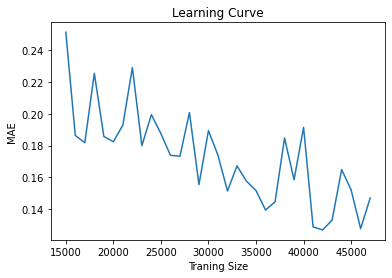

In [46]:
import matplotlib.pyplot as plt

plt.plot(list(range(15000, 48000, 1000)), MAE_list)
plt.title('Learning Curve')
plt.xlabel('Traning Size')
plt.ylabel('MAE')
plt.show()

In [50]:
min(MAE_list)

0.12677264

In [70]:
x_train_homo, x_test_homo, y_train_homo, y_test_homo = train_test_split(df_descN_all.iloc[:60000], df['homo'].iloc[:60000], 
                                                    test_size=0.2, random_state=42)

In [71]:
model_homo, score_homo = neural_model(x_train_homo, y_train_homo, x_test_homo, y_test_homo, neurons=64)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [72]:
test_predictions_homo = model_homo.predict(x_test_homo)
errors_homo = y_test_homo - test_predictions_homo.flatten()
MAE_homo = np.abs(errors_homo).mean()
MAE_homo

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.006946453

In [91]:
MAE_homo

0.006946453

In [73]:
print(f'mse: {np.mean(score_homo):.3f} \u00B1 {np.std(score_homo):.3f} ')

mse: 0.004 ± 0.003 


In [74]:
x_train_lumo, x_test_lumo, y_train_lumo, y_test_lumo = train_test_split(df_descN_all.iloc[:60000], df['lumo'].iloc[:60000], 
                                                    test_size=0.2, random_state=42)

In [75]:
model_lumo, score_lumo = neural_model(x_train_lumo, y_train_lumo, x_test_lumo, y_test_lumo, neurons=64)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [76]:
test_predictions_lumo = model_lumo.predict(x_test_lumo)
errors_lumo = y_test_lumo - test_predictions_lumo.flatten()
MAE_lumo = np.abs(errors_lumo).mean()
MAE_lumo

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.0075053684

In [94]:
MAE_lumo

0.0075053684

In [80]:
x_train_alfa, x_test_alfa, y_train_alfa, y_test_alfa = train_test_split(df_descN_all.iloc[:60000], df['alfa'].iloc[:60000], 
                                                    test_size=0.2, random_state=42)

In [81]:
model_alfa, score_alfa = neural_model(x_train_alfa, y_train_alfa, x_test_alfa, y_test_alfa, neurons=64)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [82]:
test_predictions_alfa = model_alfa.predict(x_test_alfa)
errors_alfa = y_test_alfa - test_predictions_alfa.flatten()
MAE_alfa = np.abs(errors_alfa).mean()
MAE_alfa

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.6100258

In [93]:
MAE_alfa

0.6100258

In [87]:
x_train_Cv, x_test_Cv, y_train_Cv, y_test_Cv = train_test_split(df_descN_all.iloc[:60000], df['Cv'].iloc[:60000], 
                                                    test_size=0.2, random_state=42)

In [88]:
model_Cv, score_Cv = neural_model(x_train_Cv, y_train_Cv, x_test_Cv, y_test_Cv, neurons=64)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [89]:
test_predictions_Cv = model_Cv.predict(x_test_Cv)
errors_Cv = y_test_Cv - test_predictions_Cv.flatten()
MAE_Cv = np.abs(errors_Cv).mean()
MAE_Cv

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.2000308

In [90]:
len(df)

133796

# Referências

[1] R. Ramakrishnan, P. O. Dral, M. Rupp, O. A. von Lilienfeld, Quantum chemistry structures and properties of 134 kilo molecules, *Scientific Data 1*, 140022, 2014.<br>
[2] Gilmer, J., et al. Neural message passing for quantum chemistry. *ICML17: Proceedings of the 34th International Conference on Machine Learning*, 70, 1263–1272, 2017.<br>
[3] Chen, C., et al. Graph Networks as a Universal Machine Learning Framework for Molecules and Crystals. *Chemistry of Materials*, 31, 3564-3572, 2019.<br>
[4] https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system<br>
[5] Lengeling, B. S.; Guzik, A. A. Inverse molecular design using machine learning: Generative models for matter engineering. *Science*, 361, 360 - 365, 2018.<br>
[6] Schneider, N.; Sayle, R. A.; Landrum, A. Get Your Atoms in Order—An Open-Source Implementation of a Novel and Robust Molecular Canonicalization Algorithm. *Journal of Chemical Information and Modeling*, 55, 2111-2120, 2015.<br>
[7] Chandrasekaran, B., et al. Computer-Aided Prediction of Pharmacokinetic (ADMET) Properties. *Dosage From Design Parameters - Volume II*. Advances in Pharmaceutical Product Development and Research, 731-755, 2018. <br>
[8] Pinheiro, G. A. Machine Learning Prediction of Nine Molecular Properties Based on
the SMILES Representation of the QM9 Quantum-Chemistry Dataset. *The Journal of Physical Chemistry A*, 124 (47), 9854-9866, 2020. <br>
[9] Rupp, M., et al. Fast and Accurate Modeling of Molecular Atomization Energies with Machine Learning. *PHYSICAL REVIEW LETTERS*, 108, 2012.